In [1]:
%load_ext autoreload
%autoreload 2

In [211]:
import numpy as np
from household_package.data import call_data_url
from household_package.clean import clean_data
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from household_package.model import get_xy
from household_package.clean import filter_data
from household_package.registry import load_model
import pandas as pd
from household_package.registry import save_model
import pickle
from sklearn.model_selection import cross_validate
from household_package.preprocessor import preprocessing
from google.cloud import storage
from household_package.clean import clean_data_without

In [4]:
BUCKET_NAME="01_household_energy"
LOCAL_REGISTRY_PATH = "../model_h5/loaded/"


In [9]:
columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH", "DOLLAREL"]

df = pd.read_csv("https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v6.csv",
                     usecols=columns)

small_data = pd.DataFrame(df[["state_name","KWH", "DOLLAREL"]])

small_data["price_kwh"] =  small_data["DOLLAREL"] /small_data["KWH"] 

In [18]:
small_data = pd.DataFrame(df[["state_name","KWH", "DOLLAREL"]])

In [22]:
small_data["price_kwh"] =  small_data["DOLLAREL"] /small_data["KWH"] 

In [23]:
small_data

,state_name,KWH,DOLLAREL,price_kwh
0,New Mexico,12521.48,1955.06,0.156136
1,Arkansas,5243.05,713.27,0.136041
2,New Mexico,2387.64,334.51,0.140101
3,South Carolina,9275.07,1424.86,0.153623
4,New Jersey,5869.70,1087.00,0.185188
...,...,...,...,...
18491,Maryland,5638.33,678.15,0.120275
18492,Maine,4425.20,649.96,0.146877
18493,Texas,15121.25,1428.31,0.094457
18494,South Carolina,18604.35,2222.89,0.119482


In [6]:
df_raw["DOLLAREL"]

KeyError: 'DOLLAREL'

In [3]:
user_input = user_input = {
  "TYPEHUQ": 1,
  "NHSLDMEM": 1,
  "state_name": "Alabama",
  "REGIONC": "SOUTH",
  "BA_climate": "Hot-Humid",
  "SQFTEST": 240,
  "STORIES": 1,
  "YEARMADERANGE": 1,
  "NCOMBATH": 0,
  "NHAFBATH": 0,
  "TOTROOMS": 1,
  "WALLTYPE": 1,
  "ROOFTYPE": 1,
  "WINDOWS": 1,
  "SWIMPOOL": 1,
  "SOLAR": 1,
  "SMARTMETER": 1,
  "TELLWORK": 1,
  "DESKTOP": 0,
  "NUMLAPTOP": 0,
  "TVCOLOR": 0,
  "DISHWASH": 1,
  "MICRO": 0,
  "NUMFRIG": 0,
  "CWASHER": 1,
  "DRYER": 1,
  "LGTIN1TO4": 0,
  "LGTIN4TO8": 0,
  "LGTINMORE8": 0,
  "AIRCOND": 1,
  "EQUIPM": 3,
  "HEATHOME": 1,
  "NUMPORTEL": 0
}

In [121]:
def make_X_new(user_input):
    """
    This functions takes a dictionary coming from user inputs
    and makes a one row of X for model prediciton.
    """
    ## get all the passed arguments
    #user_inputs = locals().copy()
    X_new = pd.DataFrame({k:[v] for k,v in user_input.items()})
    return X_new


In [42]:
X_new = make_X_new(user_input)

In [28]:
#X_row_new = pd.DataFrame(pd.Series(user_input)).T

In [43]:
X_row_new = clean_data(X_new)

In [44]:
X_row_new

,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,TYPEHUQ,NHSLDMEM,state_name,REGIONC,BA_climate,SQFTEST,...,MICRO,NUMFRIG,CWASHER,DRYER,AIRCOND,EQUIPM,HEATHOME,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,1,0,1,1,Mobile,1,Alabama,SOUTH,Hot-Humid,240,...,0,0,1,1,1,Furnace,1,0,0,0


In [59]:
from google.cloud import storage
client = storage.Client()
blobs = list(client.get_bucket(BUCKET_NAME).list_blobs(prefix="model"))

In [60]:
blobs

[<Blob: 01_household_energy, models/baseline_20231129-122043.pkl, 1701256844126884>,
 <Blob: 01_household_energy, models/baseline_20231129-131320.pkl, 1701260000941981>,
 <Blob: 01_household_energy, models/baseline_20231130-102940.pkl, 1701337090569311>]

In [101]:
latest_blob = max(blobs, key=lambda x: x.updated)
#print(latest_blob.name)
latest_model_path_to_save = os.path.join(LOCAL_REGISTRY_PATH, latest_blob.name)
print(latest_model_path_to_save)
latest_blob.download_to_filename(latest_model_path_to_save)
# for sklearn (baseline)
with open(latest_model_path_to_save , 'rb') as f:
    latest_model = pickle.load(f)

../model_h5/loaded/models/baseline_20231130-102940.pkl


In [70]:
latest_model.predict(X_row_new)

array([11040.])

In [31]:

#percentile_min = df_raw['KWH'].quantile(0.005)
#percentile_max = df_raw['KWH'].quantile(0.995)

# Filter the DataFrame based on the specified percentiles
#filtered_df = df_raw[(df_raw['KWH'] >= percentile_min) & (df_raw['KWH'] <= percentile_max)]
#filtered_df

In [3]:
df = clean_data(df_raw)

NameError: name 'df_raw' is not defined

In [177]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def filter_data(df,min_perc=0.005, max_perc=0.995):
    df = df.copy()

    #Get rid of outliers#
    percentile_min = df['KWH'].quantile(min_perc)
    percentile_max = df['KWH'].quantile(max_perc)

    # Filter the DataFrame based on the specified percentiles
    df = df[(df['KWH'] >= percentile_min) & (df['KWH'] <= percentile_max)]
    return df


def clean_data_2(df,min_perc=0.005, max_perc=0.995):
    """This set cleans the data to have it in the correct format before preprocessing"""

    #Maping features
    TYPEHUQ_map = {1: "Mobile", 2: "Single_detached",3: "Single_attached",
                   4: "Appartment_small" ,5: "Appartment_big"}
    
    YEARMADERANGE_map = {1: "Before_50", 2:"50-59", 3:"60-69",
                         4: "70-79", 5: "80-89", 6:"90-99", 7:"00-09",
                         8:"2010-15", 9:"2016-20" }
    EQUIPM_map = {3:"Furnace", 2: "Steam", 4: "Central_heat", 13: "Ductless_heat",
                5: "Electric_units", 7: "Room_heater", 8 : "Wood",
                10:"Electric_heater", 99:"Other", -2:"Other"}

    dics_transform = [TYPEHUQ_map, YEARMADERANGE_map, EQUIPM_map]
    columns_to_transform = ["TYPEHUQ", "YEARMADERANGE", "EQUIPM"]

    for x , y in zip(dics_transform,columns_to_transform):
        df[y] = df[y].map(x)

    #Combine new features
    df["TOTAL_BATH"] = df["NCOMBATH"] + df["NHAFBATH"]
    df.drop( ["NCOMBATH", "NHAFBATH"] ,axis=1, inplace = True)

    df["TOTAL_COMP"] = df["DESKTOP"] + df["NUMLAPTOP"]
    df.drop( ["DESKTOP", "NUMLAPTOP"] ,axis=1, inplace = True)

    df["TOTAL_LIGHT"] = df["LGTIN1TO4"] + df["LGTIN4TO8"] + df["LGTINMORE8"]
    df.drop( ["LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8"] ,axis=1, inplace = True)

    df["STORIES"] = df["STORIES"].replace(-2,1)
    df["STORIES"] = df["STORIES"].replace(5,2)

    #Impute features
    features_imputer2 = ['SWIMPOOL', 'NUMPORTEL', 'SOLAR']
    features_imputer4 = ['SMARTMETER']
    #to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ','YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

    imputer_2 = SimpleImputer(strategy='constant', missing_values=-2, fill_value=0)
    imputer_4 = SimpleImputer(strategy='constant', missing_values=-4, fill_value=0)
    #ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[('imputer_2',imputer_2, features_imputer2),
                                                ('imputer_4',imputer_4, features_imputer4)],
                                                #('ohe', ohe, to_ohe_encode)],
                                                    remainder = "passthrough")

    preprocessor.fit(df)

    cols = [x.split("__")[1] for x in preprocessor.get_feature_names_out()]

    df_clean = pd.DataFrame(preprocessor.transform(df),
                       columns = cols)

    return df_clean


In [178]:
df = call_data_url()

In [179]:
df = df.drop(["WALLTYPE", "ROOFTYPE"],axis=1)

In [180]:
df = clean_data_2(df)

In [181]:
df.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'SOLAR', 'SMARTMETER', 'REGIONC', 'state_name',
       'BA_climate', 'TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'TOTROOMS',
       'WINDOWS', 'NUMFRIG', 'MICRO', 'DISHWASH', 'CWASHER', 'DRYER',
       'TVCOLOR', 'TELLWORK', 'HEATHOME', 'EQUIPM', 'AIRCOND', 'NHSLDMEM',
       'SQFTEST', 'KWH', 'TOTAL_BATH', 'TOTAL_COMP', 'TOTAL_LIGHT'],
      dtype='object')

In [182]:
X , y = get_xy(df)

X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)

In [183]:
to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ', "EQUIPM",
                     'YEARMADERANGE', 'WINDOWS']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT" ]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


preprocessor = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

model = LinearRegression()

pipe = Pipeline([('prep', preprocessor), ('model', model)])

### Score - two features

In [184]:
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [185]:
cross_validate(pipe, X_train, y_train, cv =5)["test_score"].mean()

0.5064290079231559

In [186]:
cross_validate(pipe, X_train, y_train_p, cv =5)["test_score"].mean()

0.5390166210563248

In [187]:
pipe.fit(X_train, y_train_p)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['REGIONC', 'state_name',
                                                   'BA_climate', 'TYPEHUQ',
                                                   'EQUIPM', 'YEARMADERANGE',
                                                   'WINDOWS'])])),
                ('model', LinearRegression())])

In [188]:
pipe.score(X_test, y_test_p)

0.5248544499483565

In [215]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('min_max', MinMaxScaler(),
                                 ['NUMPORTEL', 'STORIES', 'SQFTEST', 'TOTROOMS',
                                  'NUMFRIG', 'MICRO', 'TVCOLOR', 'NHSLDMEM',
                                  'TOTAL_BATH', 'TOTAL_COMP', 'TOTAL_LIGHT']),
                                ('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['REGIONC', 'state_name', 'BA_climate',
                                  'TYPEHUQ', 'EQUIPM', 'YEARMADERANGE',
                                  'WINDOWS'])])

In [216]:
X_trans = preprocessing.transform(X_train)

AttributeError: 'function' object has no attribute 'transform'

In [198]:
preprocessor.transform(X_test)

array([[0.0, 0.3333333333333333, 0.10348360655737704, ..., 0, 1, 1],
       [0.0, 0.0, 0.07581967213114754, ..., 0, 1, 1],
       [0.0, 0.0, 0.13934426229508196, ..., 1, 0, 1],
       ...,
       [0.0, 0.0, 0.05737704918032786, ..., 0, 1, 1],
       [0.0, 0.3333333333333333, 0.11885245901639344, ..., 0, 0, 0],
       [0.0, 0.3333333333333333, 0.2827868852459017, ..., 1, 1, 1]],
      dtype=object)

In [199]:
model = LinearRegression()

In [204]:
pd.DataFrame(y_train_p)

,KWH
12406,9.299265
2216,9.169833
12653,9.929013
7637,9.655036
7773,8.503828
...,...
11333,9.552401
11213,8.983439
12809,9.314577
427,9.867064


In [210]:
y_train_p

12406    9.299265
2216     9.169833
12653    9.929013
7637     9.655036
7773     8.503828
           ...   
11333    9.552401
11213    8.983439
12809    9.314577
427      9.867064
15594    9.512615
Name: KWH, Length: 12947, dtype: float64

In [209]:
model.fit(X_trans, pd.DataFrame(y_train_p).reshape(-1,1))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [192]:
make_X_new(X_test.iloc[0,:])

,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,...,TVCOLOR,TELLWORK,HEATHOME,EQUIPM,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0,0,0,0,NORTHEAST,New York,Cold,Single_detached,2,Before_50,...,1,0,1,Furnace,1,2,1250,2,3,4


In [193]:
pipe.predict(make_X_new(X_test.iloc[0,:]))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [158]:
make_X_new(X_test.iloc[0,:])

,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,...,TVCOLOR,TELLWORK,HEATHOME,EQUIPM,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0,0,0,1,SOUTH,Florida,Hot-Humid,Single_detached,1,2016-20,...,4,0,0,Other,1,7,2200,2,1,6


In [159]:
pipe.predict(make_X_new(X_test.iloc[0,:]))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

### Score - all features

In [111]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def filter_data(df,min_perc=0.005, max_perc=0.995):
    df = df.copy()

    #Get rid of outliers#
    percentile_min = df['KWH'].quantile(min_perc)
    percentile_max = df['KWH'].quantile(max_perc)

    # Filter the DataFrame based on the specified percentiles
    df = df[(df['KWH'] >= percentile_min) & (df['KWH'] <= percentile_max)]
    return df


def clean_data(df,min_perc=0.005, max_perc=0.995):
    """This set cleans the data to have it in the correct format before preprocessing"""

    #Maping features
    TYPEHUQ_map = {1: "Mobile", 2: "Single_detached",3: "Single_attached",
                   4: "Appartment_small" ,5: "Appartment_big"}
    YEARMADERANGE_map = {1: "Before_50", 2:"50-59", 3:"60-69",
                         4: "70-79", 5: "80-89", 6:"90-99", 7:"00-09",
                         8:"2010-15", 9:"2016-20" }
    WALLTYPE_map = {1:"Brick",2:"Wood",3:"Siding",4:"Stucco",5:"Shingle",
                    6:"Stone",7:"Concrete",99:"Other"}
    ROOFTYPE_map = {1 : "Ceramic", 2 : "Wood", 3 : "Metal", 4: "Slate",
                    5: "Shingle", 6: "Concrete", 99: "Other", -2:"Other"}
    EQUIPM_map = {3:"Furnace", 2: "Steam", 4: "Central_heat", 13: "Ductless_heat",
                5: "Electric_units", 7: "Room_heater", 8 : "Wood",
                10:"Electric_heater", 99:"Other", -2:"Other"}

    dics_transform = [TYPEHUQ_map, YEARMADERANGE_map, WALLTYPE_map, ROOFTYPE_map, EQUIPM_map]
    columns_to_transform = ["TYPEHUQ", "YEARMADERANGE", "WALLTYPE", "ROOFTYPE", "EQUIPM"]

    for x , y in zip(dics_transform,columns_to_transform):
        df[y] = df[y].map(x)

    #Combine new features
    df["TOTAL_BATH"] = df["NCOMBATH"] + df["NHAFBATH"]
    df.drop( ["NCOMBATH", "NHAFBATH"] ,axis=1, inplace = True)

    df["TOTAL_COMP"] = df["DESKTOP"] + df["NUMLAPTOP"]
    df.drop( ["DESKTOP", "NUMLAPTOP"] ,axis=1, inplace = True)

    df["TOTAL_LIGHT"] = df["LGTIN1TO4"] + df["LGTIN4TO8"] + df["LGTINMORE8"]
    df.drop( ["LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8"] ,axis=1, inplace = True)

    df["STORIES"] = df["STORIES"].replace(-2,1)
    df["STORIES"] = df["STORIES"].replace(5,2)

    #Impute features
    features_imputer2 = ['SWIMPOOL', 'NUMPORTEL', 'SOLAR']
    features_imputer4 = ['SMARTMETER']
    #to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ','YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

    imputer_2 = SimpleImputer(strategy='constant', missing_values=-2, fill_value=0)
    imputer_4 = SimpleImputer(strategy='constant', missing_values=-4, fill_value=0)
    #ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[('imputer_2',imputer_2, features_imputer2),
                                                ('imputer_4',imputer_4, features_imputer4)],
                                                #('ohe', ohe, to_ohe_encode)],
                                                    remainder = "passthrough")

    preprocessor.fit(df)

    cols = [x.split("__")[1] for x in preprocessor.get_feature_names_out()]

    df_clean = pd.DataFrame(preprocessor.transform(df),
                       columns = cols)

    return df_clean

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler


to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']
to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT" ]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


preprocessor = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

model = LinearRegression()

pipe_2 = Pipeline([('prep', preprocessor), ('model', model)])

In [112]:
df = call_data_url()

In [113]:
df = clean_data(df)

In [114]:
df.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'SOLAR', 'SMARTMETER', 'REGIONC', 'state_name',
       'BA_climate', 'TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'TOTROOMS',
       'WALLTYPE', 'ROOFTYPE', 'WINDOWS', 'NUMFRIG', 'MICRO', 'DISHWASH',
       'CWASHER', 'DRYER', 'TVCOLOR', 'TELLWORK', 'HEATHOME', 'EQUIPM',
       'AIRCOND', 'NHSLDMEM', 'SQFTEST', 'KWH', 'TOTAL_BATH', 'TOTAL_COMP',
       'TOTAL_LIGHT'],
      dtype='object')

In [115]:
X , y = get_xy(df)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)

y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [116]:
cross_validate(pipe_2, X_train, y_train, cv =5)["test_score"].mean()

0.48715139693386833

In [117]:
cross_validate(pipe_2, X_train, y_train_p, cv =5)["test_score"].mean()

0.5400254484470768

In [118]:
pipe_2.fit(X_train, y_train_p)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['REGIONC', 'state_name',
                                                   'BA_climate', 'TYPEHUQ',
                                                   'YEARMADERANGE', 'WALLTYPE',
                                                   'ROOFTYPE', 'WINDOWS',
                                                   'EQUIPM'])])),
                ('model', LinearRegression())])

In [119]:
pipe_2.score(X_test, y_test_p)

0.5259557463577558

### Random Regressor

In [2]:
df = call_data_url()

In [3]:
df = filter_data(df)
df = clean_data(df)

In [6]:
df.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'SOLAR', 'SMARTMETER', 'REGIONC', 'state_name',
       'BA_climate', 'TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'TOTROOMS',
       'WALLTYPE', 'ROOFTYPE', 'WINDOWS', 'NUMFRIG', 'MICRO', 'DISHWASH',
       'CWASHER', 'DRYER', 'TVCOLOR', 'TELLWORK', 'HEATHOME', 'EQUIPM',
       'AIRCOND', 'NHSLDMEM', 'SQFTEST', 'KWH', 'TOTAL_BATH', 'TOTAL_COMP',
       'TOTAL_LIGHT'],
      dtype='object')

In [7]:
df["SQFTEST"].min()

240

In [317]:
X , y = get_xy(df)
X_train , X_test, y_train , y_test = train_test_split(X, y , test_size=0.3)

In [43]:
#Needed for X predict
pd.DataFrame(X.iloc[0,:]).T

,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,...,TVCOLOR,TELLWORK,HEATHOME,EQUIPM,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
0,0,0,0,0,WEST,New Mexico,Mixed-Dry,Single_detached,1,70-79,...,3,0,1,Furnace,1,2,2100,3,1,17


In [318]:
from sklearn.ensemble import RandomForestRegressor

to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT" ]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


preprocessor = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

model = RandomForestRegressor()

pipe_2 = Pipeline([('prep', preprocessor), ('model', model)])

In [13]:
pipe_2.fit(X_train,y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['REGIONC', 'state_name',
                                                   'BA_climate', 'TYPEHUQ',
                                                   'YEARMADERANGE', 'WALLTYPE',
                                                   'ROOFTYPE', 'WINDOWS',
                                                   'EQUIPM'])])),
                ('model', RandomForestRegressor())])

In [15]:
pipe_2.score(X_test,y_test)

0.46195432428379035

In [320]:
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('min_max', MinMaxScaler(),
                                 ['NUMPORTEL', 'STORIES', 'SQFTEST', 'TOTROOMS',
                                  'NUMFRIG', 'MICRO', 'TVCOLOR', 'NHSLDMEM',
                                  'TOTAL_BATH', 'TOTAL_COMP', 'TOTAL_LIGHT']),
                                ('ohe',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['REGIONC', 'state_name', 'BA_climate',
                                  'TYPEHUQ', 'YEARMADERANGE', 'WALLTYPE',
                                  'ROOFTYPE', 'WINDOWS', 'EQUIPM'])])

In [321]:
X_train_prep = preprocessor.transform(X_train)

In [322]:
model = RandomForestRegressor()

In [323]:
model.fit(X_train_prep, y_train)

RandomForestRegressor()

In [331]:
pd.set_option('display.max_rows', None)

rfg_df = pd.DataFrame(model.feature_importances_, index=preprocessor.get_feature_names_out())

rfg_df.reset_index().sort_values(by="index")

,index,0
5,min_max__MICRO,0.005087
7,min_max__NHSLDMEM,0.057803
4,min_max__NUMFRIG,0.030783
0,min_max__NUMPORTEL,0.018243
2,min_max__SQFTEST,0.188624
1,min_max__STORIES,0.008564
8,min_max__TOTAL_BATH,0.016074
9,min_max__TOTAL_COMP,0.024478
10,min_max__TOTAL_LIGHT,0.055183
3,min_max__TOTROOMS,0.046265


### Testing model with all values

In [266]:
df = call_data_url()

In [267]:
df = filter_data(df)

In [268]:
df = clean_data(df)

In [269]:
X , y = get_xy(df)

In [270]:
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [271]:
prep = preprocessing(X_train)

In [272]:
X_trans = prep.transform(X_train)

In [273]:
model = LinearRegression()

In [274]:
model.fit(X_trans, y_train)

LinearRegression()

In [275]:
cross_validate(model , X_trans, y_train, cv=5 )["test_score"].mean()

0.49268817807784976

In [276]:
cross_validate(model , X_trans, y_train_p, cv=5 )["test_score"].mean()

0.5366381288240587

In [277]:
X_test_trans = prep.transform(X_test)

In [293]:
pd.DataFrame(X_test_trans[0]).T

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,0.077053,0.285714,0.111111,0.333333,0.071429,0.5,0.2,0.090909,...,0.0,0,0,0,1,1,1,1,1,1


In [294]:
model.predict(pd.DataFrame(X_test_trans[0]).T)

array([9544.])

### Without FINAL FEATURES

In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def clean_data_2(df,min_perc=0.005, max_perc=0.995):
    """This set cleans the data to have it in the correct format before preprocessing"""

    #Maping features
    TYPEHUQ_map = {1: "Mobile", 2: "Single_detached",3: "Single_attached",
                   4: "Appartment_small" ,5: "Appartment_big"}
    
    YEARMADERANGE_map = {1: "Before_50", 2:"50-59", 3:"60-69",
                         4: "70-79", 5: "80-89", 6:"90-99", 7:"00-09",
                         8:"2010-15", 9:"2016-20" }
    EQUIPM_map = {3:"Furnace", 2: "Steam", 4: "Central_heat", 13: "Ductless_heat",
                5: "Electric_units", 7: "Room_heater", 8 : "Wood",
                10:"Electric_heater", 99:"Other", -2:"Other"}

    dics_transform = [TYPEHUQ_map, YEARMADERANGE_map, EQUIPM_map]
    columns_to_transform = ["TYPEHUQ", "YEARMADERANGE", "EQUIPM"]

    for x , y in zip(dics_transform,columns_to_transform):
        df[y] = df[y].map(x)

    #Combine new features
    df["TOTAL_BATH"] = df["NCOMBATH"] + df["NHAFBATH"]
    df.drop( ["NCOMBATH", "NHAFBATH"] ,axis=1, inplace = True)

    df["TOTAL_COMP"] = df["DESKTOP"] + df["NUMLAPTOP"]
    df.drop( ["DESKTOP", "NUMLAPTOP"] ,axis=1, inplace = True)

    df["TOTAL_LIGHT"] = df["LGTIN1TO4"] + df["LGTIN4TO8"] + df["LGTINMORE8"]
    df.drop( ["LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8"] ,axis=1, inplace = True)

    df["STORIES"] = df["STORIES"].replace(-2,1)
    df["STORIES"] = df["STORIES"].replace(5,2)

    #Impute features
    features_imputer2 = ['SWIMPOOL', 'NUMPORTEL']
    features_imputer4 = ['SMARTMETER']
    #to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ','YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

    imputer_2 = SimpleImputer(strategy='constant', missing_values=-2, fill_value=0)
    imputer_4 = SimpleImputer(strategy='constant', missing_values=-4, fill_value=0)
    #ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[('imputer_2',imputer_2, features_imputer2),
                                                ('imputer_4',imputer_4, features_imputer4)],
                                                #('ohe', ohe, to_ohe_encode)],
                                                    remainder = "passthrough")

    preprocessor.fit(df)

    cols = [x.split("__")[1] for x in preprocessor.get_feature_names_out()]

    df_clean = pd.DataFrame(preprocessor.transform(df),
                       columns = cols)

    return df_clean


In [223]:
#df = df.drop(["WALLTYPE", "ROOFTYPE"], axis = 1)

In [39]:
df_new = call_data_url()
df = df_new.drop(["WALLTYPE", "ROOFTYPE", "REGIONC", "TELLWORK", "SOLAR"], axis = 1)
df = filter_data(df)
df = clean_data_2(df)
X , y = get_xy(df)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [14]:
X_train.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'SMARTMETER', 'state_name', 'BA_climate',
       'TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'TOTROOMS', 'WINDOWS', 'NUMFRIG',
       'MICRO', 'DISHWASH', 'CWASHER', 'DRYER', 'TVCOLOR', 'HEATHOME',
       'EQUIPM', 'AIRCOND', 'NHSLDMEM', 'SQFTEST', 'TOTAL_BATH', 'TOTAL_COMP',
       'TOTAL_LIGHT'],
      dtype='object')

In [15]:
from sklearn.ensemble import RandomForestRegressor

to_ohe_encode = ['state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WINDOWS','EQUIPM']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT" ]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first")


prep2 = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

pipe = Pipeline([("prep", prep2 ),("model", LinearRegression())])

In [40]:
pipe.fit(X_train, y_train_p)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['state_name', 'BA_climate',
                                                   'TYPEHUQ', 'YEARMADERANGE',
                                                   'WINDOWS', 'EQUIPM'])])),
                ('model', LinearRegression())])

In [17]:
for x , y  in zip(pipe[:-1].get_feature_names_out() ,pipe.named_steps["model"].coef_):
    print(x , y)

min_max__NUMPORTEL 0.290060292674696
min_max__STORIES -0.05338230656321219
min_max__SQFTEST 0.9411860235586804
min_max__TOTROOMS 0.08424222764146344
min_max__NUMFRIG 0.6886966428141479
min_max__MICRO 0.03028809885738415
min_max__TVCOLOR 0.7632924113710898
min_max__NHSLDMEM 0.4729620958431085
min_max__TOTAL_BATH 0.13090136991239426
min_max__TOTAL_COMP 0.31204688000685676
min_max__TOTAL_LIGHT 0.581625517292549
ohe__state_name_Alaska -0.3455645439218956
ohe__state_name_Arizona -0.07513859412034157
ohe__state_name_Arkansas 0.025557898309221866
ohe__state_name_California -0.5782082990175554
ohe__state_name_Colorado -0.33352953969122817
ohe__state_name_Connecticut -0.3881251692727359
ohe__state_name_Delaware -0.21135489348809355
ohe__state_name_District of Columbia -0.21471160740655443
ohe__state_name_Florida -0.04353149334893619
ohe__state_name_Georgia -0.10176467847159365
ohe__state_name_Hawaii -0.46678755845144815
ohe__state_name_Idaho -0.16691145858462444
ohe__state_name_Illinois -0.2936

In [25]:
scores = cross_validate(pipe, X_train, y_train_p, cv = 5, scoring = ["r2", "neg_mean_absolute_error"])

In [41]:
from sklearn.metrics import mean_absolute_error

In [42]:
y_pred = pipe.predict(X_test)

In [43]:
y_pred_converted = np.exp(y_pred)

In [47]:
mean_absolute_error(y_test, y_pred_converted)/ y.mean()

0.30247216639127394

In [57]:
y.astype("float").describe()

count    18310.000000
mean     10703.136279
std       6407.761653
min       1186.210000
25%       5954.002500
50%       9346.435000
75%      14074.417500
max      38007.280000
Name: KWH, dtype: float64

In [54]:
y.min(), y.max()

(1186.21, 38007.28)

In [46]:
y.mean()

10703.136279082466

In [52]:
y.median()

9346.435000000001

In [30]:
pipe.predict(X_test, y_test_p)

0.5290910328015777

In [48]:
sum_errs = np.sum((y_test - y_pred_converted)**2)

In [49]:
stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)

In [51]:
one_minus_pi = 1 - 0.95
ppf_lookup = 1 - (one_minus_pi / 2)


In [29]:
np.exp(scores['test_neg_mean_absolute_error'].mean())

0.7190377045699009

## Elastic Net

In [22]:
df_new = call_data_url()
df = df_new.drop(["WALLTYPE", "ROOFTYPE"], axis = 1)
df = filter_data(df)
df = clean_data_without(df)
X , y = get_xy(df)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [31]:
X_train

,SWIMPOOL,NUMPORTEL,SOLAR,SMARTMETER,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,...,TVCOLOR,TELLWORK,HEATHOME,EQUIPM,AIRCOND,NHSLDMEM,SQFTEST,TOTAL_BATH,TOTAL_COMP,TOTAL_LIGHT
2004,0,0,0,0,SOUTH,Georgia,Mixed-Humid,Single_detached,2,2016-20,...,4,0,1,Furnace,1,2,2980,3,1,22
1580,0,0,0,0,SOUTH,Kentucky,Mixed-Humid,Single_detached,1,Before_50,...,2,0,1,Furnace,1,5,1180,1,0,12
2558,0,0,0,0,SOUTH,North Carolina,Mixed-Humid,Single_detached,1,60-69,...,1,0,1,Furnace,1,1,1650,2,0,3
17282,0,0,0,0,SOUTH,Virginia,Mixed-Humid,Single_detached,1,50-59,...,1,0,1,Furnace,1,1,1250,1,0,2
12635,1,1,0,0,WEST,California,Hot-Dry,Single_detached,2,Before_50,...,3,1,1,Furnace,1,3,3070,4,2,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7481,0,0,0,0,WEST,Nevada,Hot-Dry,Appartment_big,1,90-99,...,1,0,1,Furnace,1,2,620,1,0,8
4068,0,0,0,0,NORTHEAST,Connecticut,Cold,Single_detached,1,70-79,...,2,0,1,Electric_units,1,2,1700,2,2,15
13600,0,2,0,1,WEST,Oregon,Cold,Single_detached,1,Before_50,...,1,0,1,Electric_heater,0,1,1300,2,1,5
7729,0,0,0,1,MIDWEST,Ohio,Cold,Mobile,1,00-09,...,3,0,1,Furnace,1,4,1280,2,3,17


In [32]:
from sklearn.linear_model import ElasticNet

to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WINDOWS','EQUIPM']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT" ]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')


prep2 = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

pipe = Pipeline([("prep", prep2 ),("model", ElasticNet())])

In [28]:
from sklearn.model_selection import GridSearchCV

In [33]:
params = {'model__alpha':[0.001, 0.01, 0.1, 1, 10], 
          'model__l1_ratio':[0.1,0.2, 0.5,0.8]}

In [34]:
search = GridSearchCV(pipe, param_grid=params)

In [35]:
search.fit(X_train, y_train_p)

GridSearchCV(estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('min_max',
                                                                         MinMaxScaler(),
                                                                         ['NUMPORTEL',
                                                                          'STORIES',
                                                                          'SQFTEST',
                                                                          'TOTROOMS',
                                                                          'NUMFRIG',
                                                                          'MICRO',
                                                                          'TVCOLOR',
                                                                          'NHSLDMEM',
                                                                          'TOTAL_BATH',
                                                                          'TOTAL_COMP',
                                                                          'TOTAL_LIGHT']),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['REGIONC',
                                                                          'state_name',
                                                                          'BA_climate',
                                                                          'TYPEHUQ',
                                                                          'YEARMADERANGE',
                                                                          'WINDOWS',
                                                                          'EQUIPM'])])),
                                       ('model', ElasticNet())]),
             param_grid={'model__alpha': [0.001, 0.01, 0.1, 1, 10],
                         'model__l1_ratio': [0.1, 0.2, 0.5, 0.8]})

In [36]:
search.best_score_

0.5422175834725463

In [30]:
cross_validate(pipe, X_train, y_train_p, cv =5 )

{'fit_time': array([0.12209702, 0.13957977, 0.14752269, 0.1435442 , 0.14555979]),
 'score_time': array([0.03126574, 0.02787924, 0.02887201, 0.04096174, 0.02188373]),
 'test_score': array([-1.75000429e-06, -2.31601231e-06, -1.36734691e-06, -4.78692418e-04,
        -5.80409686e-04])}

In [15]:
X_trans = prep2.transform(X_train)
X_trans_test = prep2.transform(X_test)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
model = LinearRegression()
model.fit(X_trans, y_train)

In [309]:
cross_validate(model , X_trans, y_train, cv=5 )["test_score"].mean()

0.49769718217717623

In [310]:
cross_validate(model , X_trans, y_train_p, cv=5 )["test_score"].mean()

0.5302786418145256

In [339]:
from household_package.registry import load_model_locally_log
import os 

In [340]:
client = storage.Client()
blobs = list(client.get_bucket(BUCKET_NAME).list_blobs(prefix="model"))
print(blobs)
    #print(blobs)
latest_blob = max(blobs, key=lambda x: x.updated)
        #print(latest_blob.name)
latest_model_path_to_save = os.path.join(LOCAL_REGISTRY_PATH, latest_blob.name)
latest_blob.download_to_filename(latest_model_path_to_save)

with open(latest_model_path_to_save , 'rb') as f:
    latest_model = pickle.load(f)

[<Blob: 01_household_energy, models/baseline_20231129-122043.pkl, 1701256844126884>, <Blob: 01_household_energy, models/baseline_20231129-131320.pkl, 1701260000941981>, <Blob: 01_household_energy, models/baseline_20231130-102940.pkl, 1701337090569311>, <Blob: 01_household_energy, models/baseline_20231201-151102.pkl, 1701439862204187>]


In [341]:
latest_model

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT']),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['REGIONC', 'state_name',
                                                   'BA_climate', 'TYPEHUQ',
                                                   'YEARMADERANGE', 'WINDOWS',
                                                   'EQUIPM'])])),
                ('model', LinearRegression())])

In [346]:
X , y = get_xy(df)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [347]:
latest_model.score(X_test, y_test_p)

0.5491828147668718

### Final model

In [287]:
columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH", "DOLLAREL"]

df = pd.read_csv("https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v6.csv",
                     usecols=columns)

#small_data = pd.DataFrame(df[["state_name","KWH", "DOLLAREL"]])

df["PRICEKWH"] =  small_data["DOLLAREL"] /small_data["KWH"] 

In [286]:
df = df.drop(["WALLTYPE", "ROOFTYPE", "TELLWORK","SOLAR", "SMARTMETER", "REGIONC", "DOLLAREL"], axis = 1)
df = filter_data(df)

KeyError: 'PRICEKWH'

In [117]:
df_prices = df[["PRICEKWH", "state_name"]].groupby("state_name").mean()

In [283]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def clean_data_2(df,min_perc=0.005, max_perc=0.995):
    """This set cleans the data to have it in the correct format before preprocessing"""

    #Maping features
    TYPEHUQ_map = {1: "Mobile", 2: "Single_detached",3: "Single_attached",
                   4: "Appartment_small" ,5: "Appartment_big"}
    
    YEARMADERANGE_map = {1: "Before_50", 2:"50-59", 3:"60-69",
                         4: "70-79", 5: "80-89", 6:"90-99", 7:"00-09",
                         8:"2010-15", 9:"2016-20" }
    EQUIPM_map = {3:"Furnace", 2: "Steam", 4: "Central_heat", 13: "Ductless_heat",
                5: "Electric_units", 7: "Room_heater", 8 : "Wood",
                10:"Electric_heater", 99:"Other", -2:"Other"}

    dics_transform = [TYPEHUQ_map, YEARMADERANGE_map, EQUIPM_map]
    columns_to_transform = ["TYPEHUQ", "YEARMADERANGE", "EQUIPM"]

    for x , y in zip(dics_transform,columns_to_transform):
        df[y] = df[y].map(x)

    #Combine new features
    df["TOTAL_BATH"] = df["NCOMBATH"] + df["NHAFBATH"]
    df.drop( ["NCOMBATH", "NHAFBATH"] ,axis=1, inplace = True)

    df["TOTAL_COMP"] = df["DESKTOP"] + df["NUMLAPTOP"]
    df.drop( ["DESKTOP", "NUMLAPTOP"] ,axis=1, inplace = True)

    df["TOTAL_LIGHT"] = df["LGTIN1TO4"] + df["LGTIN4TO8"] + df["LGTINMORE8"]
    df.drop( ["LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8"] ,axis=1, inplace = True)

    df["STORIES"] = df["STORIES"].replace(-2,1)
    df["STORIES"] = df["STORIES"].replace(5,2)

    #Impute features
    features_imputer2 = ['SWIMPOOL', 'NUMPORTEL']
    #features_imputer4 = ['SMARTMETER']
    #to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ','YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

    imputer_2 = SimpleImputer(strategy='constant', missing_values=-2, fill_value=0)
    #imputer_4 = SimpleImputer(strategy='constant', missing_values=-4, fill_value=0)
    #ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[('imputer_2',imputer_2, features_imputer2)],
                                                #('imputer_4',imputer_4, features_imputer4)],
                                                #('ohe', ohe, to_ohe_encode)],
                                                  remainder = "passthrough")

    preprocessor.fit(df)

    cols = [x.split("__")[1] for x in preprocessor.get_feature_names_out()]

    df_clean = pd.DataFrame(preprocessor.transform(df),
                       columns = cols)

    return df_clean


In [119]:
df = clean_data_2(df)


In [120]:
X , y = get_xy(df)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [121]:
X_train.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'state_name', 'BA_climate', 'TYPEHUQ',
       'STORIES', 'YEARMADERANGE', 'TOTROOMS', 'WINDOWS', 'NUMFRIG', 'MICRO',
       'DISHWASH', 'CWASHER', 'DRYER', 'TVCOLOR', 'HEATHOME', 'EQUIPM',
       'AIRCOND', 'NHSLDMEM', 'SQFTEST', 'PRICEKWH', 'TOTAL_BATH',
       'TOTAL_COMP', 'TOTAL_LIGHT'],
      dtype='object')

In [122]:
from sklearn.linear_model import ElasticNet

to_ohe_encode = [ 'state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WINDOWS','EQUIPM']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT", "PRICEKWH"]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first")


prep2 = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

pipe = Pipeline([("prep", prep2 ),("model", LinearRegression())])

In [123]:
pipe.fit(X_train, y_train_p)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT', 'PRICEKWH']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['state_name', 'BA_climate',
                                                   'TYPEHUQ', 'YEARMADERANGE',
                                                   'WINDOWS', 'EQUIPM'])])),
                ('model', LinearRegression())])

In [124]:
pipe.score(X_test, y_test_p)

0.572853213976854

In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [126]:
y_pred_p = pipe.predict(X_test)

In [127]:
mean_absolute_error(y_test, np.exp(y_pred_p))

3135.7808291375063

In [128]:
cross_validate(pipe, X_train, y_train_p, cv =5 )["test_score"].mean()

0.5757597455288275

In [129]:
for x , y  in zip(pipe[:-1].get_feature_names_out() ,pipe.named_steps["model"].coef_):
    print(x , y)

min_max__NUMPORTEL 0.24722175283311656
min_max__STORIES -0.042483199835906815
min_max__SQFTEST 0.8264717472690042
min_max__TOTROOMS 0.07421464424131424
min_max__NUMFRIG 0.6601044282079953
min_max__MICRO 0.015667748327637482
min_max__TVCOLOR 0.695213597491376
min_max__NHSLDMEM 0.4488233431403609
min_max__TOTAL_BATH 0.15602516491201834
min_max__TOTAL_COMP 0.36992441184291336
min_max__TOTAL_LIGHT 0.5244048707783837
min_max__PRICEKWH -3.5721271675045325
ohe__state_name_Alaska -0.07270424286591581
ohe__state_name_Arizona 0.006612417934493353
ohe__state_name_Arkansas -0.04914496202576524
ohe__state_name_California -0.3433782948442836
ohe__state_name_Colorado -0.37378245629575435
ohe__state_name_Connecticut -0.00702851741072219
ohe__state_name_Delaware -0.21634039611645606
ohe__state_name_District of Columbia -0.27114923744087727
ohe__state_name_Florida -0.07789123737712123
ohe__state_name_Georgia -0.11327419579253495
ohe__state_name_Hawaii -0.06547495063686148
ohe__state_name_Idaho -0.164930

### Final

In [329]:
columns = ["REGIONC", "state_name", "BA_climate", "TYPEHUQ", "STORIES", "YEARMADERANGE", "NCOMBATH", "NHAFBATH", "TOTROOMS", "WALLTYPE", "ROOFTYPE", "WINDOWS",
           "SWIMPOOL", "NUMFRIG", "MICRO", "DISHWASH", "CWASHER", "DRYER", "TVCOLOR", "DESKTOP", "NUMLAPTOP",
           "TELLWORK","HEATHOME", "EQUIPM", "NUMPORTEL", "AIRCOND", "LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8", "SMARTMETER", "SOLAR", "NHSLDMEM", "SQFTEST",
          "KWH", "DOLLAREL"]

df = pd.read_csv("https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v6.csv",
                     usecols=columns)

#small_data = pd.DataFrame(df[["state_name","KWH", "DOLLAREL"]])

df["PRICEKWH"] =  df["DOLLAREL"] /df["KWH"] 

df = filter_data(df)
df = df.drop(["WALLTYPE", "ROOFTYPE", "TELLWORK",  "REGIONC", "DOLLAREL", "SOLAR", "SMARTMETER"], axis = 1)
df = clean_data_2(df)
#X , y = get_xy(df)
X = df.drop('KWH',axis=1)
y = df['KWH']
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [330]:
def filter_data(df,min_perc=0.005, max_perc=0.995):
    df = df.copy()

    #Get rid of outliers#
    percentile_min = df['KWH'].quantile(min_perc)
    percentile_max = df['KWH'].quantile(max_perc)
    #percentile_min_price = df['PRICEKWH'].quantile(min_perc)
    #percentile_max_price = df['PRICEKWH'].quantile(max_perc)

    # Filter the DataFrame based on the specified percentiles
    df = df[(df['KWH'] >= percentile_min) & (df['KWH'] <= percentile_max)]
    df = df[(df['PRICEKWH'] > 0.01) & (df['PRICEKWH'] <= 0.9)]

    return df

In [298]:
df_2 = pd.read_csv("https://www.eia.gov/consumption/residential/data/2020/csv/recs2020_public_v6.csv",
                     usecols=columns)

df_2["PRICEKWH"] =  df_2["DOLLAREL"] /df_2["KWH"] 

df = filter_data(df_2)
#18292

In [299]:
df["SMARTMETER"].value_counts()

-4    7685
 0    5687
 1    4920
Name: SMARTMETER, dtype: int64

In [306]:
df[df["SMARTMETER"]<1].KWH.mean()

10411.9746343105

In [305]:
df[df["SMARTMETER"]>0].KWH.mean()

11498.592461382113

In [263]:
df["PRICEKWH"].describe()

count    18292.000000
mean         0.143897
std          0.053326
min          0.000000
25%          0.110947
50%          0.127741
75%          0.164836
max          0.889866
Name: PRICEKWH, dtype: float64

In [222]:
df_2[df_2["DOLLAREL"] < 0]

,REGIONC,state_name,BA_climate,TYPEHUQ,STORIES,YEARMADERANGE,NCOMBATH,NHAFBATH,TOTROOMS,WALLTYPE,...,LGTIN1TO4,LGTIN4TO8,LGTINMORE8,SMARTMETER,SOLAR,NHSLDMEM,SQFTEST,KWH,DOLLAREL,PRICEKWH


In [224]:
lst = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 ,0.8, 0.9, 0.99,1]

In [225]:
for x in lst:
    print(df["PRICEKWH"].astype("float").quantile(x))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.100e+01, 3.200e+01, 7.100e+01, 4.400e+01, 5.200e+01,
        7.400e+01, 8.800e+01, 1.440e+02, 5.280e+02, 1.840e+03, 3.115e+03,
        3.067e+03, 2.134e+03, 1.453e+03, 9.370e+02, 6.690e+02, 7.100e+02,
        6.590e+02, 3.680e+02, 5.090e+02, 4.530e+02, 2.940e+02, 2.290e+02,
        1.550e+02, 1.270e+02, 1.850e+02, 1.390e+02, 4.900e+01, 4.400e+01,
        4.200e+01, 2.900e+01, 1.700e+01, 1.100e+01, 6.000e+00, 1.000e+00,
        4.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

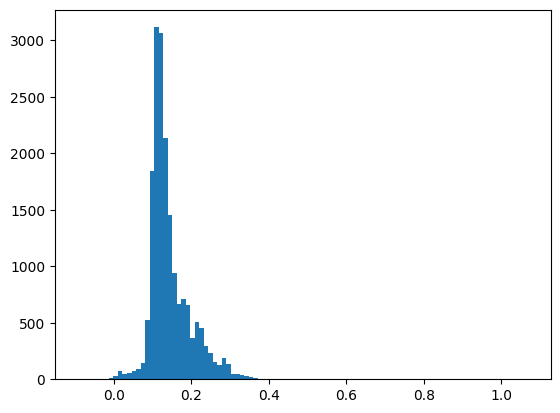

In [162]:
import matplotlib.pyplot as plt
plt.hist(df["PRICEKWH"], bins = 100)

In [331]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

to_ohe_encode = [ 'state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WINDOWS','EQUIPM']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT"]

to_standard = ["PRICEKWH"]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop="first")
std = StandardScaler()


prep2 = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode),
                                            ('std',std ,to_standard)
                                            ],
                                            remainder = "passthrough")

pipe = Pipeline([("prep", prep2 ),("model", LinearRegression())])

In [332]:
X_train.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'state_name', 'BA_climate', 'TYPEHUQ',
       'STORIES', 'YEARMADERANGE', 'TOTROOMS', 'WINDOWS', 'NUMFRIG', 'MICRO',
       'DISHWASH', 'CWASHER', 'DRYER', 'TVCOLOR', 'HEATHOME', 'EQUIPM',
       'AIRCOND', 'NHSLDMEM', 'SQFTEST', 'PRICEKWH', 'TOTAL_BATH',
       'TOTAL_COMP', 'TOTAL_LIGHT'],
      dtype='object')

In [333]:
X_train["PRICEKWH"].min()

0.010105929043274054

In [334]:
pipe.fit(X_train, y_train_p)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max', MinMaxScaler(),
                                                  ['NUMPORTEL', 'STORIES',
                                                   'SQFTEST', 'TOTROOMS',
                                                   'NUMFRIG', 'MICRO',
                                                   'TVCOLOR', 'NHSLDMEM',
                                                   'TOTAL_BATH', 'TOTAL_COMP',
                                                   'TOTAL_LIGHT']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['state_name', 'BA_climate',
                                                   'TYPEHUQ', 'YEARMADERANGE',
                                                   'WINDOWS', 'EQUIPM']),
                                                 ('std', StandardScaler(),
                                                  ['PRICEKWH'])])),
                ('model', LinearRegression())])

In [335]:
cross_validate(pipe, X_train, y_train_p, cv =5 )["test_score"].mean()

0.5790267146865771

In [327]:
y_pred_p = pipe.predict(X_test)
mean_absolute_error(y_test, np.exp(y_pred_p))

3200.6611040414537

In [272]:
for x , y  in zip(pipe[:-1].get_feature_names_out() ,pipe.named_steps["model"].coef_):
    print(x , y)

min_max__NUMPORTEL 0.25978967937168235
min_max__STORIES -0.0626391400814903
min_max__SQFTEST 0.9650832125787602
min_max__TOTROOMS 0.05649003660920848
min_max__NUMFRIG 0.4987407164579375
min_max__MICRO -0.006914036715581426
min_max__TVCOLOR 0.5522557843880816
min_max__NHSLDMEM 0.4582862908142105
min_max__TOTAL_BATH 0.13703726603708785
min_max__TOTAL_COMP 0.32816030838482535
min_max__TOTAL_LIGHT 0.6098023647072832
ohe__state_name_Alaska -0.019474598040472163
ohe__state_name_Arizona -0.013007215065343032
ohe__state_name_Arkansas -0.02617837281701277
ohe__state_name_California -0.3684797625020034
ohe__state_name_Colorado -0.3121517876586444
ohe__state_name_Connecticut 0.0612436075540231
ohe__state_name_Delaware -0.17642409381514995
ohe__state_name_District of Columbia -0.2622917560508409
ohe__state_name_Florida -0.051320382953008836
ohe__state_name_Georgia -0.05727683488701848
ohe__state_name_Hawaii -2.5544274856181826e-05
ohe__state_name_Idaho -0.15112375088707025
ohe__state_name_Illinois

In [279]:
user_input = {
  "TYPEHUQ": 2,
  "SQFTEST": 1530,
  "NHSLDMEM": 2,
  "state_name": "California",
  "PRICEKWH": 0.2999,
  "BA_climate": "Cold",
  "SWIMPOOL": 0,
  "TOTROOMS": 6,
  "STORIES": 1,
  "YEARMADERANGE": 4,
  "SMARTMETER": 0,
  "NCOMBATH": 2,
  "NHAFBATH": 0,
  "EQUIPM": 3,
  "WINDOWS": 4,
  "DESKTOP": 0,
  "NUMLAPTOP": 0,
  "MICRO": 1,
  "CWASHER": 1,
  "AIRCOND": 1,
  "NUMPORTEL": 0,
  "TVCOLOR": 2,
  "NUMFRIG": 1,
  "DRYER": 1,
  "DISHWASH": 1,
  "LGTIN1TO4": 4,
  "LGTIN4TO8": 0,
  "LGTINMORE8": 0,
  "HEATHOME": 1
}

In [280]:
X_new = pd.DataFrame(user_input, index=[0])
X_new = clean_data_2(X_new)
    ##### Create new dataframe from user inputs ######
    #X_new = pd.DataFrame({k:[int(v) if v.isdigit() else v] for k,v in params.items()})

    # # ## clean the dataframe
y_pred = pipe.predict(X_new)[0]
y_pred = np.exp(y_pred)
y_pred

3509.4336582508536

#### Linear Regression

In [9]:
df_new = call_data_url()
df = df_new.drop(["WALLTYPE", "ROOFTYPE", "TELLWORK","SOLAR", "SMARTMETER", "REGIONC"], axis = 1)
df = filter_data(df)
df = clean_data_2(df)

X , y = get_xy(df)
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.3)
y_train_p = np.log(y_train.astype("float"))
y_test_p = np.log(y_test.astype("float"))

In [34]:
X_train.columns

Index(['state_name', 'BA_climate', 'TYPEHUQ', 'STORIES', 'YEARMADERANGE',
       'NCOMBATH', 'NHAFBATH', 'TOTROOMS', 'WINDOWS', 'SWIMPOOL', 'NUMFRIG',
       'MICRO', 'DISHWASH', 'CWASHER', 'DRYER', 'TVCOLOR', 'DESKTOP',
       'NUMLAPTOP', 'HEATHOME', 'EQUIPM', 'NUMPORTEL', 'AIRCOND', 'LGTIN1TO4',
       'LGTIN4TO8', 'LGTINMORE8', 'NHSLDMEM', 'SQFTEST', 'PRICEKWH'],
      dtype='object')

In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def clean_data_2(df,min_perc=0.005, max_perc=0.995):
    """This set cleans the data to have it in the correct format before preprocessing"""

    #Maping features
    TYPEHUQ_map = {1: "Mobile", 2: "Single_detached",3: "Single_attached",
                   4: "Appartment_small" ,5: "Appartment_big"}
    
    YEARMADERANGE_map = {1: "Before_50", 2:"50-59", 3:"60-69",
                         4: "70-79", 5: "80-89", 6:"90-99", 7:"00-09",
                         8:"2010-15", 9:"2016-20" }
    EQUIPM_map = {3:"Furnace", 2: "Steam", 4: "Central_heat", 13: "Ductless_heat",
                5: "Electric_units", 7: "Room_heater", 8 : "Wood",
                10:"Electric_heater", 99:"Other", -2:"Other"}

    dics_transform = [TYPEHUQ_map, YEARMADERANGE_map, EQUIPM_map]
    columns_to_transform = ["TYPEHUQ", "YEARMADERANGE", "EQUIPM"]

    for x , y in zip(dics_transform,columns_to_transform):
        df[y] = df[y].map(x)

    #Combine new features
    df["TOTAL_BATH"] = df["NCOMBATH"] + df["NHAFBATH"]
    df.drop( ["NCOMBATH", "NHAFBATH"] ,axis=1, inplace = True)

    df["TOTAL_COMP"] = df["DESKTOP"] + df["NUMLAPTOP"]
    df.drop( ["DESKTOP", "NUMLAPTOP"] ,axis=1, inplace = True)

    df["TOTAL_LIGHT"] = df["LGTIN1TO4"] + df["LGTIN4TO8"] + df["LGTINMORE8"]
    df.drop( ["LGTIN1TO4", "LGTIN4TO8", "LGTINMORE8"] ,axis=1, inplace = True)

    df["STORIES"] = df["STORIES"].replace(-2,1)
    df["STORIES"] = df["STORIES"].replace(5,2)

    #Impute features
    features_imputer2 = ['SWIMPOOL', 'NUMPORTEL']
    features_imputer4 = ['SMARTMETER']
    #to_ohe_encode = ['REGIONC', 'state_name','BA_climate','TYPEHUQ','YEARMADERANGE','WALLTYPE','ROOFTYPE','WINDOWS','EQUIPM']

    imputer_2 = SimpleImputer(strategy='constant', missing_values=-2, fill_value=0)
    imputer_4 = SimpleImputer(strategy='constant', missing_values=-4, fill_value=0)
    #ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    preprocessor = ColumnTransformer(transformers=[('imputer_2',imputer_2, features_imputer2),
                                                #('imputer_4',imputer_4, features_imputer4)],
                                                #('ohe', ohe, to_ohe_encode)],
                                                  ], remainder = "passthrough")

    preprocessor.fit(df)

    cols = [x.split("__")[1] for x in preprocessor.get_feature_names_out()]

    df_clean = pd.DataFrame(preprocessor.transform(df),
                       columns = cols)

    return df_clean


In [78]:
df.columns

Index(['SWIMPOOL', 'NUMPORTEL', 'SMARTMETER', 'REGIONC', 'state_name',
       'BA_climate', 'TYPEHUQ', 'STORIES', 'YEARMADERANGE', 'TOTROOMS',
       'WINDOWS', 'NUMFRIG', 'MICRO', 'DISHWASH', 'CWASHER', 'DRYER',
       'TVCOLOR', 'HEATHOME', 'EQUIPM', 'AIRCOND', 'NHSLDMEM', 'SQFTEST',
       'KWH', 'TOTAL_BATH', 'TOTAL_COMP', 'TOTAL_LIGHT'],
      dtype='object')

In [33]:
to_ohe_encode = ['state_name','BA_climate','TYPEHUQ',
                     'YEARMADERANGE','WINDOWS','EQUIPM']

to_scale = ["NUMPORTEL", "STORIES","SQFTEST",
            "TOTROOMS", "NUMFRIG", "MICRO", "TVCOLOR","NHSLDMEM",
            "TOTAL_BATH", "TOTAL_COMP", "TOTAL_LIGHT","PRICEKWH" ]

min_max = MinMaxScaler()
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop="first")


prep2 = ColumnTransformer(transformers=[
                                            ('min_max', min_max, to_scale),
                                            ('ohe', ohe, to_ohe_encode)],
                                            remainder = "passthrough")

pipe = Pipeline([("prep", prep2 ),("model", LinearRegression())])

In [80]:
#with Tellwork
cross_validate(pipe, X_train, y_train_p, cv=5)["test_score"].mean()

0.5401287742107884

In [81]:
#without Tellwork
cross_validate(pipe, X_train, y_train_p, cv=5)["test_score"].mean()

0.5401287742107884

In [88]:
cross_validate(pipe, X_train, y_train_p, cv=5)["test_score"].mean()

0.5380990169092557

In [97]:
np.sort(df["state_name"].unique())

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
price_december = [0.1483, 0.245, 0.1439]

In [97]:
df_price = pd.read_csv("prices_electricity.csv",  encoding="ISO-8859-1")

In [98]:
df_price["Current Month"] = df_price["Current Month"].apply( lambda x : round(pd.to_numeric(x[:-1])/100,4))

In [99]:
state_name = pd.DataFrame(df["state_name"].unique())

In [100]:
df_price.merge(state_name,left_on = "State", right_on = 0 )

,State,Current Month,Previous Month,0
0,Alabama,0.1483,14.14¢,Alabama
1,Alaska,0.2450,25.07¢,Alaska
2,Arizona,0.1439,13.82¢,Arizona
3,Arkansas,0.1267,12.45¢,Arkansas
4,California,0.2999,29.84¢,California
5,Colorado,0.1503,14.43¢,Colorado
6,Connecticut,0.2925,27.89¢,Connecticut
7,Delaware,0.1583,15.66¢,Delaware
8,District of Columbia,0.1628,16.4¢,District of Columbia
9,Florida,0.1551,14.93¢,Florida


In [101]:
price_dictionary = dict(zip(df_price["State"], df_price["Current Month"]))

In [108]:
price_dictionary

{'Alabama': 0.1483,
 'Alaska': 0.245,
 'Arizona': 0.1439,
 'Arkansas': 0.1267,
 'California': 0.2999,
 'Colorado': 0.1503,
 'Connecticut': 0.2925,
 'Delaware': 0.1583,
 'District of Columbia': 0.1628,
 'Florida': 0.1551,
 'Georgia': 0.1401,
 'Hawaii': 0.4152,
 'Idaho': 0.116,
 'Illinois': 0.1479,
 'Indiana': 0.141,
 'Iowa': 0.1403,
 'Kansas': 0.1346,
 'Kentucky': 0.1243,
 'Louisiana': 0.1139,
 'Maine': 0.2686,
 'Maryland': 0.1696,
 'Massachusetts': 0.28,
 'Michigan': 0.1935,
 'Minnesota': 0.1529,
 'Mississippi': 0.1305,
 'Missouri': 0.1423,
 'Montana': 0.1318,
 'Nebraska': 0.1239,
 'Nevada': 0.1694,
 'New Hampshire': 0.2331,
 'New Jersey': 0.1802,
 'New Mexico': 0.1525,
 'New York': 0.2323,
 'North Carolina': 0.1409,
 'North Dakota': 0.1277,
 'Ohio': 0.1568,
 'Oklahoma': 0.1325,
 'Oregon': 0.1313,
 'Pennsylvania': 0.1801,
 'Rhode Island': 0.2694,
 'South Carolina': 0.1452,
 'South Dakota': 0.1305,
 'Tennessee': 0.1185,
 'Texas': 0.1458,
 'Utah': 0.1185,
 'Vermont': 0.2121,
 'Virginia':

In [109]:
df_prices["PRICEKWH"].index.map(price_dictionary)

Float64Index([0.1483,  0.245, 0.1439, 0.1267, 0.2999, 0.1503, 0.2925, 0.1583,
              0.1628, 0.1551, 0.1401, 0.4152,  0.116, 0.1479,  0.141, 0.1403,
              0.1346, 0.1243, 0.1139, 0.2686, 0.1696,   0.28, 0.1935, 0.1529,
              0.1305, 0.1423, 0.1318, 0.1239, 0.1694, 0.2331, 0.1802, 0.1525,
              0.2323, 0.1409, 0.1277, 0.1568, 0.1325, 0.1313, 0.1801, 0.2694,
              0.1452, 0.1305, 0.1185, 0.1458, 0.1185, 0.2121, 0.1479, 0.1138,
              0.1438, 0.1732, 0.1264],
             dtype='float64', name='state_name')

In [113]:
df_prices["old_dictionary"] = df_prices["PRICEKWH"].index.map(price_dictionary)

In [114]:
df_prices

,PRICEKWH,new,old_dictionary
state_name,,,
Alabama,0.134450,0.1483,0.1483
Alaska,0.230086,0.2450,0.2450
Arizona,0.133130,0.1439,0.1439
Arkansas,0.117027,0.1267,0.1267
California,0.184395,0.2999,0.2999
Colorado,0.112385,0.1503,0.1503
Connecticut,0.236640,0.2925,0.2925
Delaware,0.126730,0.1583,0.1583
District of Columbia,0.122590,0.1628,0.1628


In [96]:
df_price[["State", "Current Month"]].set_index("State")

NameError: name 'df_price' is not defined

In [161]:
import csv


In [162]:
with open('dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in price_dictionary.items():
       writer.writerow([key, value])

In [74]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 16.5 MB/s eta 0:00:00m eta 0:00:010:00:01
Note: you may need to restart the kernel to use updated packages.
